# Advanced Lane Finding
***

**The goal is to write a software pipeline to identify the lane boundaries in a video**

In [91]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [ ]:
# import pdb; pdb.set_trace()

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt

import pickle
%matplotlib inline

import matplotlib.image as mpimg

import os

In [540]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 33/720 # meters per pixel in y dimension
xm_per_pix = 3.7/480 # meters per pixel in x dimension

In [455]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
LeftLane = Line()
RightLane = Line()

## 0. Camera Calibration
the first thing is to compute the camera calibration matrix and distortion coefficients. You only need to compute these once, and then you'll apply them to undistort each new frame.

**Extract object points and image points from calibration images**

In [1]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
#         write_name = 'corners_found'+str(idx)+'.jpg'
#         cv2.imwrite(write_name, img)
        
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

**If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  The cell below calculates distortion coefficients, and save dist and mtx to disk**

In [ ]:
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [ ]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

In [11]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

## Process Each Image

In [649]:
# Read and test on an image
img = mpimg.imread('test_images/mytest2.jpg')

## 1. Distortion Correction

Text(0.5, 1.0, 'Undistorted Image')

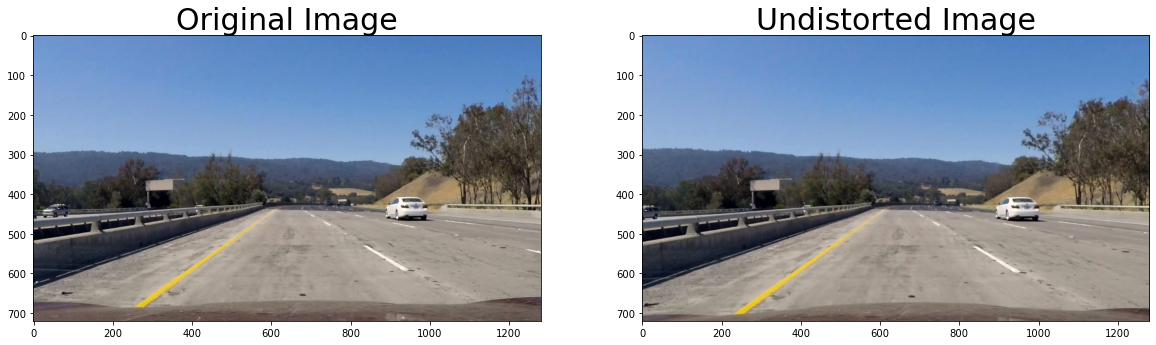

In [650]:
def undistortion(img, mtx, dist):

    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undst

undst = undistortion(img, mtx, dist)

cv2.imwrite('output_images/test_undist.jpg',undst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)

## 2. Color/Gradient Threshold

In [52]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

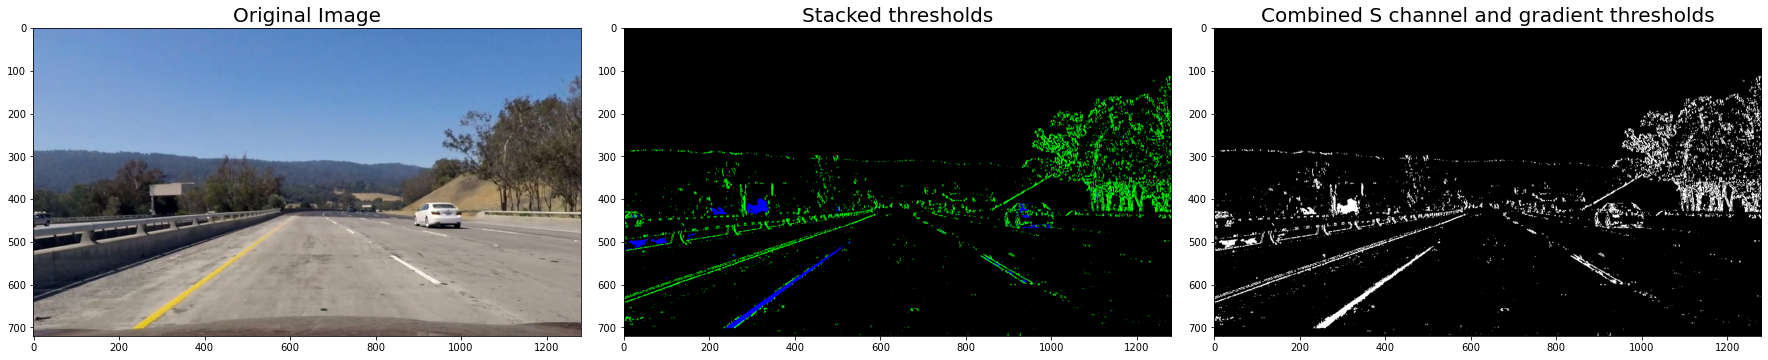

In [651]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg


# image = mpimg.imread('test_images/straight_lines1.jpg')

# Edit this function to create your own pipeline.
def edgefinding(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    r_channel = img[:,:,0]
#     g_channel = img[:,:,1]
#     b_channel = img[:,:,2]    
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#     h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    
    # Sobel x
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.Sobel(r_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Plot to check each color channel
#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
#     f.tight_layout()

#     ax1.imshow(r_channel, cmap='gray')
#     ax1.set_title('R channel', fontsize=20)

#     ax2.set_title('L channel', fontsize=20)
#     ax2.imshow(scaled_sobel, cmap='gray')

#     ax3.set_title('S channel', fontsize=20)
#     ax3.imshow(s_channel, cmap='gray')

#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    
#     return color_binary
    return  color_binary, combined_binary

color_binary, combined_binary = edgefinding(undst, s_thresh=(170, 255), sx_thresh=(20, 100))
# import pdb; pdb.set_trace()

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undst)
ax1.set_title('Original Image', fontsize=20)

ax2.set_title('Stacked thresholds', fontsize=20)
ax2.imshow(color_binary)

ax3.set_title('Combined S channel and gradient thresholds', fontsize=20)
ax3.imshow(combined_binary, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 3. Perspective Transform

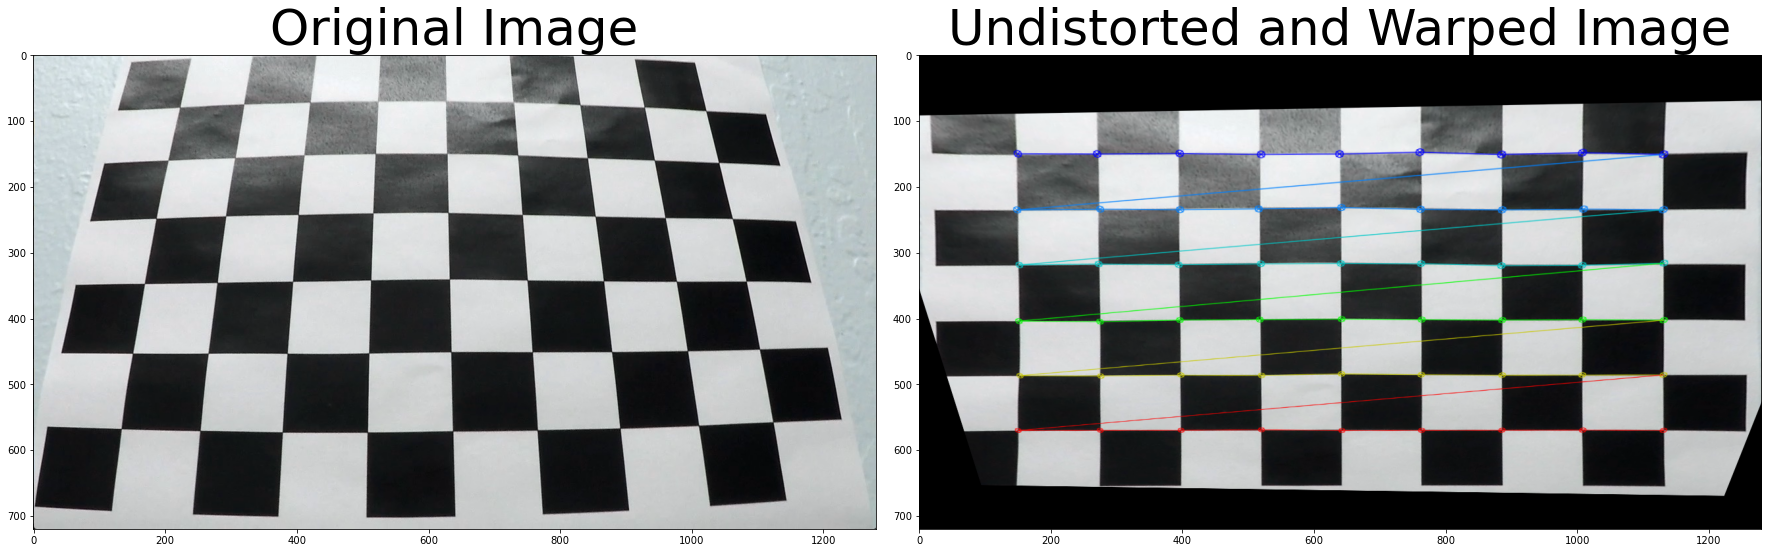

In [12]:
# import pickle
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg



# Read in an image
img = cv2.imread('camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 150 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


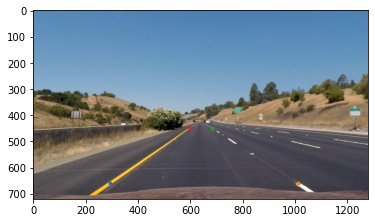

In [526]:
# import pickle
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
# dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
# mtx = dist_pickle["mtx"]
# dist = dist_pickle["dist"]

# Read in an image
img = mpimg.imread('test_images/straight_lines1.jpg') #1280*720
undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/straight_lines1_undist.jpg',cv2.cvtColor(undist, cv2.COLOR_RGB2BGR))
plt.imshow(undist)
plt.plot(294,659,'.')
plt.plot(1012,659,'.')
plt.plot(683,449,'.')
plt.plot(597,449,'.')

True

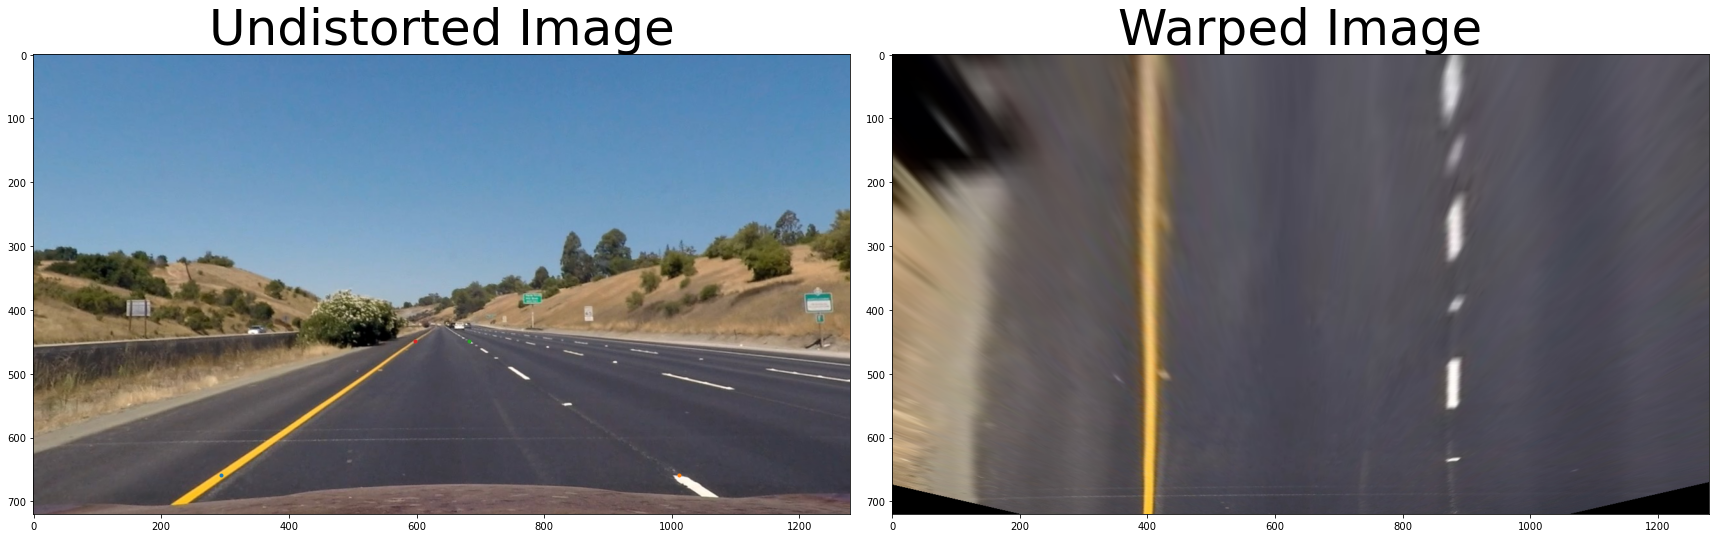

In [539]:
# U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.
# For source points I'm grabbing the outer four detected corners
src = np.float32([[294,659], [1012,659], [683,449], [597,449]])
# src = np.float32([[139,719], [1118,719], [679,445], [600,445]])
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
# dst = np.float32([[447.5, 700], [842.5, 700], [842.5, 0], [447.5, 0]])
dst = np.float32([[400, 720], [880, 720], [880, 0], [400, 0]])
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# img_marked = mpimg.imread('output_images/straight_lines1_undist_marked.jpg') 
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
                  
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.plot(294,659,'.')
ax1.plot(1012,659,'.')
ax1.plot(683,449,'.')
ax1.plot(597,449,'.')
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)                  
cv2.imwrite('output_images/straight_lines1_warped.jpg',cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))             

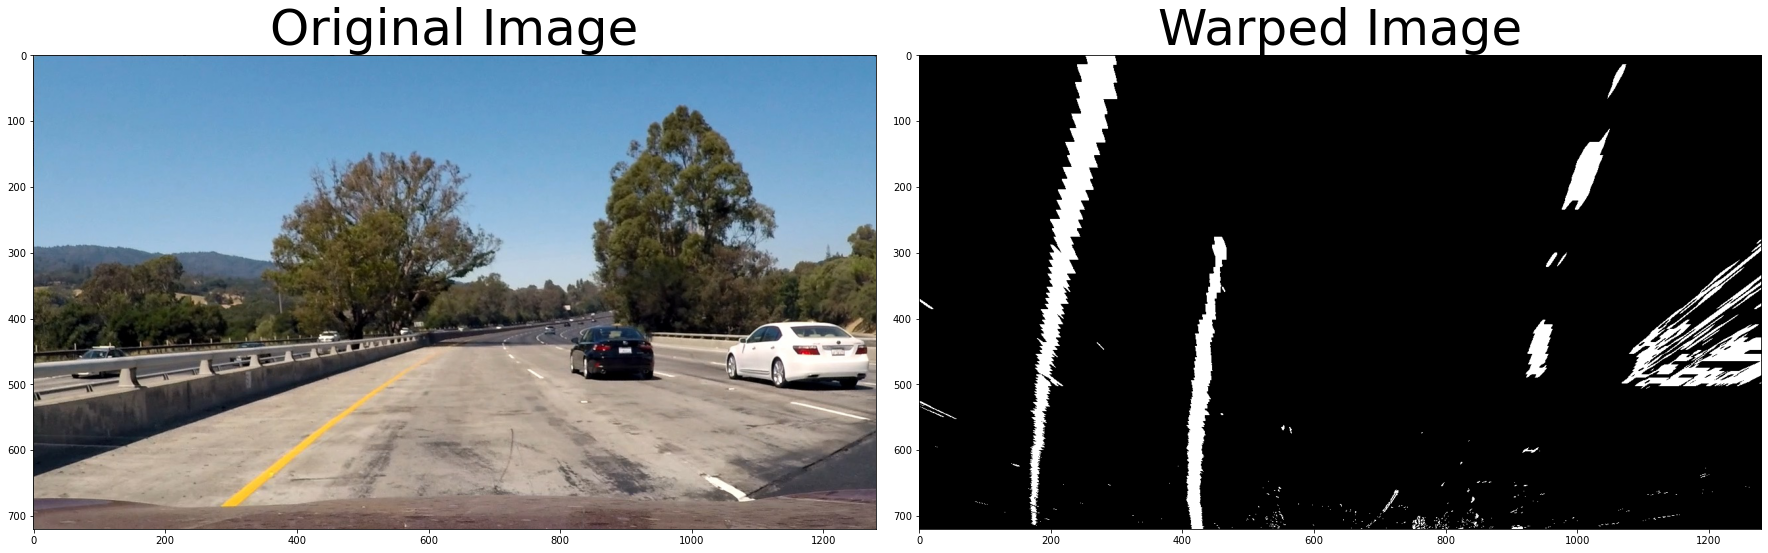

In [575]:
     
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def warp(img):

    # Warp the image using OpenCV warpPerspective()
    binary_warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return binary_warped

# img = mpimg.imread('test_images/test6.jpg') #1280*720
# undist = cv2.undistort(img, mtx, dist, None, mtx)
# img = combined_binary
binary_warped = warp(combined_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Detect Lane Lines: Histogram Peaks, Sliding Windows and Fit a Polynomial

**Find pixels that are considered lane pixels. If no previous fit, use histogram and slideing windows. Otherwise, search around previous fit.**

**Input: Topdown view binary warped image. Output: Detected left and right lane pixels, an image with searching area highlighted in green for visulization**

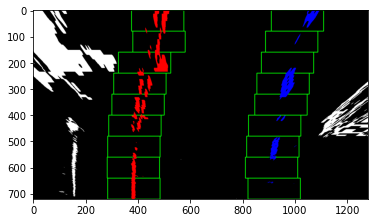

In [551]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#     plt.plot(histogram)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
#     leftx_base = np.argmax(histogram[:midpoint])
#     rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    leftx_base = np.argmax(histogram[midpoint//2:midpoint]) + midpoint//2
    rightx_base = np.argmax(histogram[midpoint:midpoint//2*3]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return leftx, lefty, rightx, righty, out_img

leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
plt.imshow(out_img)

**Use the previous polynomial to skip the sliding window**

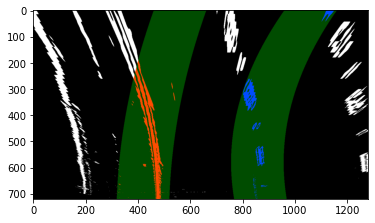

In [481]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Get the pixels within the +/- margin of the previous frame polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
   
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
       
    return leftx, lefty, rightx, righty, out_img

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
leftx, lefty, rightx, righty, out_img  = search_around_poly(binary_warped)

# View your output
plt.imshow(out_img)

**Fit polynomial**

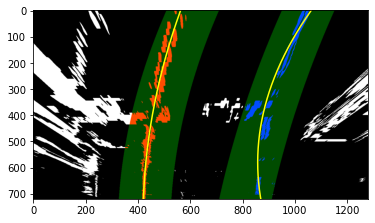

In [465]:
# Polynomial fit values from the previous frame
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

leftx, lefty, rightx, righty, out_img  = search_around_poly(binary_warped)

# Fit new polynomials
left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)


# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
## End visualization steps ##
plt.imshow(out_img)

In [466]:
def fit_polynomial(img_shape, leftx, lefty, rightx, righty):

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fit, right_fit, ploty, left_fitx, right_fitx 

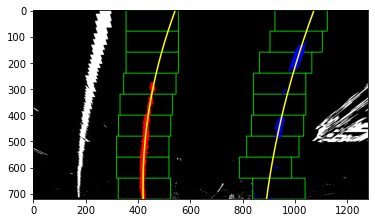

In [576]:
# Draw fit curve on warped image for visulization
# Find our lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
# leftx, lefty, rightx, righty, out_img  = search_around_poly(binary_warped)

left_fit, right_fit, ploty, left_fitx, right_fitx = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)

## Visualization ##
# Colors in the left and right lane regions
# out_img[lefty, leftx] = [255, 0, 0]
# out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

## 5. Determine the Lane Curvature

In [447]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr
    

In [554]:
def measure_curvature_real(img_shape, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
#     # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
#     ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    left_fit_cr = left_fit
    right_fit_cr = right_fit
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
#     y_eval = np.max(ploty)
    y_eval = img_shape[0] * ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    A_left = xm_per_pix/ym_per_pix**2*left_fit_cr[0]
    B_left = xm_per_pix/ym_per_pix*left_fit_cr[1]
    left_curverad = ((1 + (2*A_left*y_eval + B_left)**2)**1.5) / np.absolute(2*A_left)
    A_right = xm_per_pix/ym_per_pix**2*right_fit_cr[0]
    B_right = xm_per_pix/ym_per_pix*right_fit_cr[1]
    right_curverad = ((1 + (2*A_right*y_eval + B_right)**2)**1.5) / np.absolute(2*A_right)

#     import pdb; pdb.set_trace()
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(img.shape, left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

1129.5000737245339 m 454.65634863480636 m


## 6. Project Lanes from Topdown View to Camera View for Drawing

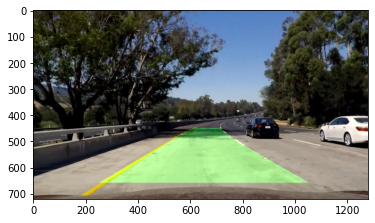

In [555]:
# Inputs: a warped binary image called warped, ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines
def unwarp(warped, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
#     # Combine the result with the original image
#     result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    
    return newwarp

unwarped = unwarp(binary_warped, ploty, left_fitx, right_fitx)   

# Combine the result with the original image
result = cv2.addWeighted(undst, 1, unwarped, 0.3, 0)
plt.imshow(result)

In [556]:
def find_lane_base_real(left_fitx, right_fitx, img_shape):
    left_lane_pos = (left_fitx[-1] - img_shape[1]*0.5) * xm_per_pix
    right_lane_pos = (right_fitx[-1] - img_shape[1]*0.5) * xm_per_pix   
    offset = ((left_fitx[-1] + right_fitx[-1])*0.5 - img_shape[1]*0.5) * xm_per_pix

    return left_lane_pos, right_lane_pos, offset

left_lane_pos, right_lane_pos, offset = find_lane_base_real(left_fitx, right_fitx, img.shape)
print(left_lane_pos, 'm', right_lane_pos, 'm', offset, 'm')

-2.072849031239229 m 2.080752546222991 m 0.003951757491880699 m


In [561]:
def addtext(img, text1, text2):

    org1 = (50, 50)
    org2 = (50, 100)
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 1
    color = (255,255,255)
    thickness = 2
    
    out_img = cv2.putText(img, text1, org1, font, fontScale, color, thickness)
    out_img = cv2.putText(img, text2, org2, font, fontScale, color, thickness) 
    
    return out_img
    

In [559]:
def sanity_check(left_curverad, right_curverad, left_lane_pos, right_lane_pos):
    if abs(left_curverad-right_curverad) > 250:
        return 1
    if abs(right_lane_pos-left_lane_pos)>4.5 or abs(right_lane_pos-left_lane_pos)<3:
        return 2
    
    return 0
        

In [473]:
def update_lane(left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_curverad, right_curverad):
    # was the line detected in the last iteration?
    LeftLane.detected = True  
    # x values of the last n fits of the line
    LeftLane.recent_xfitted = LeftLane.current_fit 
    #average x values of the fitted line over the last n iterations
    LeftLane.bestx = None     
    #polynomial coefficients averaged over the last n iterations
    LeftLane.best_fit = None  
    #polynomial coefficients for the most recent fit
    LeftLane.current_fit = left_fit  
    #radius of curvature of the line in some units 
    LeftLane.radius_of_curvature = left_curverad 
    #distance in meters of vehicle center from the line
    LeftLane.line_base_pos = left_fitx[-1] 
    #difference in fit coefficients between last and new fits
    LeftLane.diffs = np.array([0,0,0], dtype='float') 
    #x values for detected line pixels
    LeftLane.allx = leftx  
    #y values for detected line pixels
    LeftLane.ally = lefty     
    

## Pipeline

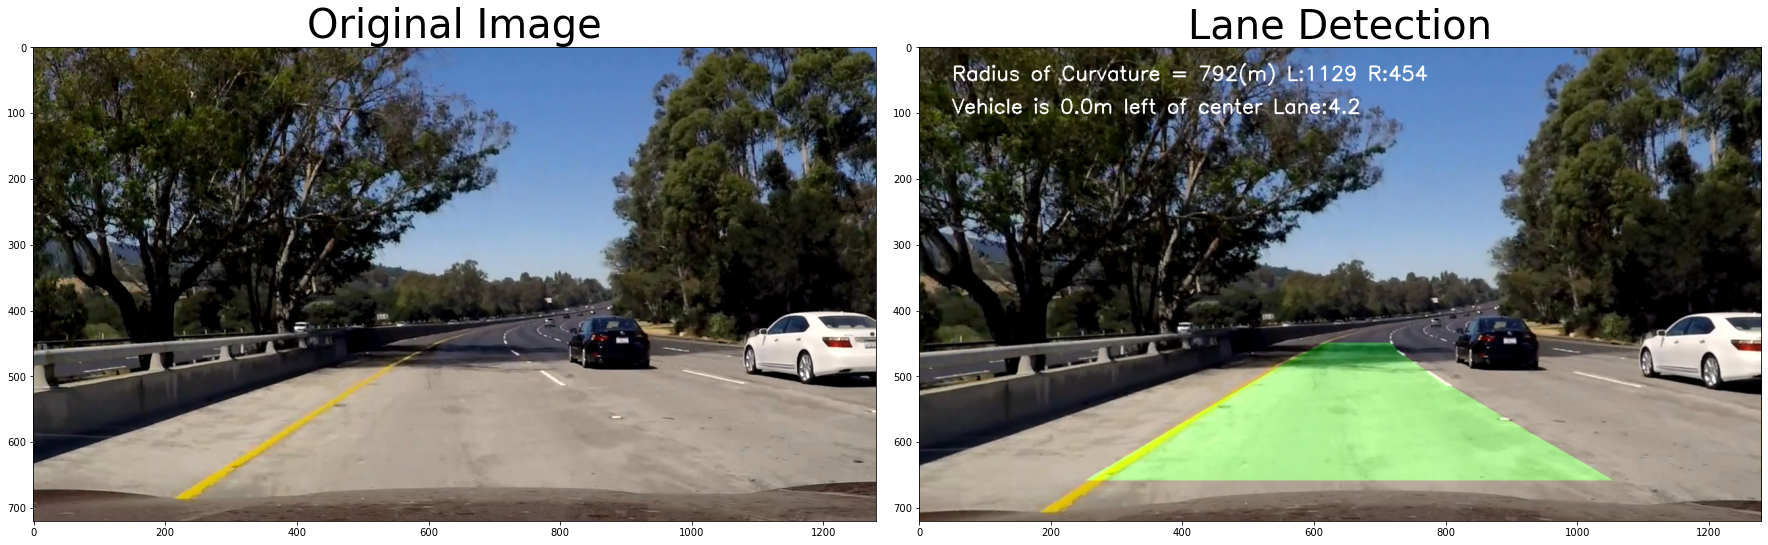

In [646]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

LeftLane = Line()
RightLane = Line()
# image = mpimg.imread('test_images/straight_lines1.jpg')

# Edit this function to create your own pipeline.
def draw_lane_lines(img):
    
    undst = undistortion(img, mtx, dist)
    
#     color_binary, combined_binary = edgefinding(undst, s_thresh=(150, 255), sx_thresh=(20, 100))   
    color_binary, combined_binary = edgefinding(undst, s_thresh=(150, 255), sx_thresh=(20, 100))
#     plt.imshow(color_binary)     
    binary_warped = warp(combined_binary)  
    
#     LeftLane.detected = False
#     print(LeftLane.detected)
    if LeftLane.detected and RightLane.detected:
        leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped)
    else:
        leftx, lefty, rightx, righty, out_img  = find_lane_pixels(binary_warped)
        
    left_fit, right_fit, ploty, left_fitx, right_fitx = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)    

    yellow = [255,255,0]
    for i in range(-3,3):
        out_img[ploty.astype(int),left_fitx.astype(int)+i] = yellow
        out_img[ploty.astype(int),right_fitx.astype(int)+i] = yellow
        
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.imshow(out_img)   
    
    left_curverad, right_curverad = measure_curvature_real(binary_warped.shape, left_fit, right_fit)
#     print(left_curverad, 'm', right_curverad, 'm')   
    
    left_lane_pos, right_lane_pos, offset = find_lane_base_real(left_fitx, right_fitx, img.shape)
#     print(left_lane_pos, 'm', right_lane_pos, 'm', offset, 'm')
    
    valid = sanity_check(left_curverad, right_curverad, left_lane_pos, right_lane_pos)
    
    update_lane(left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_curverad, right_curverad)  
    
    unwarped = unwarp(binary_warped, ploty, left_fitx, right_fitx) 
    
    # Combine the result with the original image
    img_with_lane = cv2.addWeighted(undst, 1, unwarped, 0.3, 0)  
    
    # write some key numbers for checking
    
    curvature = int(0.5*(left_curverad+right_curverad))
    text1 = 'Radius of Curvature = ' + str(curvature) + '(m)' + ' L:' +  str(int(left_curverad)) + ' R:' +  str(int(right_curverad))
    offset = ((left_fitx[-1] + right_fitx[-1])*0.5 - img.shape[1]*0.5) * xm_per_pix
    offset = round(offset,2)
    if offset >= 0:
        text2 = 'Vehicle is ' + str(offset) + 'm left of center' + ' Lane:' +  str(round(right_lane_pos-left_lane_pos,1)) 
    else:
        text2 = 'Vehicle is ' + str(-offset) + 'm right of center' + ' Lane:' +  str(round(right_lane_pos-left_lane_pos,1))    
    
    result = addtext(img_with_lane, text1, text2)    
  
#     return a camera image with lane detected and drawn

    return result, out_img

# Read and test on an image
# img = mpimg.imread('test_images/straight_lines1.jpg')
img = mpimg.imread('test_images/mytest3.jpg')
result, out_img = draw_lane_lines(img)

# import pdb; pdb.set_trace()
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.set_title('Lane Detection', fontsize=40)
ax2.imshow(result)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

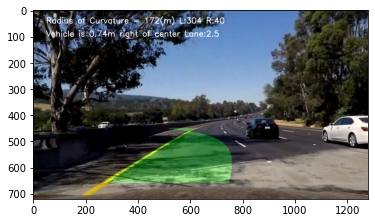

In [656]:
folder_in = 'test_images/'
filenames = os.listdir(folder_in)
filenames = ['mytest6.jpg']

folder_out = 'output_images/'
if not os.path.exists(folder_out): os.makedirs(folder_out)

# reading in an image
for filename in filenames:
    image = mpimg.imread(folder_in + filename)
#     cv2.imwrite('test_images/z.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
#     plt.imshow(image) 
    image_lanes, img_polyfit = draw_lane_lines(image)
    plt.imshow(image_lanes)
    cv2.imwrite(folder_out + filename, cv2.cvtColor(image_lanes, cv2.COLOR_RGB2BGR))
    cv2.imwrite(folder_out + 'polyfit_' + filename, cv2.cvtColor(img_polyfit, cv2.COLOR_RGB2BGR))

## Test on Videos

In [144]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [647]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result, out_img = draw_lane_lines(image)
    return result

In [653]:
LeftLane = Line()
RightLane = Line()

folder_in = './'
folder_out = 'test_videos_output/'

video_name = 'project_video.mp4'
# video_name = 'challenge_video.mp4'
# video_name = 'harder_challenge_video.mp4'
output_path = folder_out + video_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip(video_name).subclip(38,42)
# clip1 = VideoFileClip(video_name)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output_path, audio=False)

t:   0%|                                                                                  | 0/100 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4




t:  46%|███████████████████████████████▉                                     | 583/1260 [1:01:46<02:34,  4.38it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
Wall time: 29.1 s


In [644]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))